In [3]:
# install dependencies
%pip install -q amplpy matplotlib pandas

Note: you may need to restart the kernel to use updated packages.


In [23]:
# Step 1: Import AMPL and Initialize Notebook Integration
# --------------------------------------------------------
# This step sets up the AMPL environment using amplpy in a Jupyter Notebook.
# - `ampl_notebook()` installs the solvers you need (e.g., CBC, HiGHS)
# - It also initializes the magic commands for inline AMPL execution.
# - The 'default' license allows use of free solvers.

from amplpy import AMPL, ampl_notebook

# Initialize AMPL with selected solver modules and license
ampl = ampl_notebook(
    modules=["cbc", "highs"],     # Solvers to install and use
    license_uuid="default"        # Use the default license (free tier)
)


In [24]:
# Step 2: Define Decision Variables
# ---------------------------------
# In this production planning problem, there are five decision variables:
# - Three for the **resources used**: raw material, labor A, and labor B
# - Two for the **products produced**: high-end product U and low-end product V

from amplpy import AMPL

# Create AMPL environment
ampl = AMPL()

# Declare decision variables in AMPL
ampl.eval("""
    reset;  # Clear any previous definitions in the AMPL session

    # Decision Variables:

    var xM >= 0;              # xM: Total grams of raw material used (must be ≥ 0)

    var xA >= 0, <= 80;       # xA: Hours of Labor A used (max 80 hours/week)

    var xB >= 0, <= 100;      # xB: Hours of Labor B used (max 100 hours/week)

    var yU >= 0, <= 40;       # yU: Units of high-end product U to produce (max 40 due to demand)

    var yV >= 0;              # yV: Units of low-end product V to produce (unlimited demand)
""")


In [25]:
# Step 3: Define the Objective Function (Profit Maximization)
# ------------------------------------------------------------
# In this production planning problem, the company wants to maximize profits.
# Profit is calculated as total revenue from selling products U and V
# minus the costs of raw materials and labor.

ampl.eval("""
# Objective function: Maximize Profit
maximize Profit:
    270 * yU      # Revenue from high-end product U
  + 210 * yV      # Revenue from low-end product V
  - 10  * xM      # Raw material cost
  - 50  * xA      # Labor A cost
  - 40  * xB;     # Labor B cost
""")


In [26]:
# Step 4: Define Constraints
# --------------------------
# Constraints in AMPL restrict how decision variables can be combined.
# Each constraint:
# - Begins with the keyword `subject to` (can also use `subj to`, `s.t.`, or omit entirely)
# - Includes a name for reference
# - Ends with a semicolon `;`
# - Uses relational operators (<=, >=, =) to express resource limits

ampl.eval("""
# Raw material constraint: ensure material used in products ≤ material ordered
subj to raw_materials:
    10 * yU + 9 * yV <= xM;

# Labor A constraint: total Labor A hours used by both products ≤ 80
subj to labor_A:
    2 * yU + 1 * yV <= xA;

# Labor B constraint: total Labor B hours used by both products ≤ 100
subj to labor_B:
    1 * yU + 1 * yV <= xB;
""")


In [29]:
# Step 5: Apply the Model
# -----------------------
# In this step, we set the solver to 'cbc' and apply the model to compute the optimal solution.
# No results are displayed yet — that comes in the next step.

# Set the solver (must be one of the modules loaded in Step 1)
ampl.set_option('solver', 'cbc')

# Solve the model
ampl.eval("""
solve;
""")


cbc 2.10.12:cbc 2.10.12: optimal solution; objective 2400
0 simplex iterations


In [30]:
# Step 6A: Retrieve solution values using get_solution()
# -------------------------------------------------------
# This function returns a dictionary with variable names as keys and their values as values.
# By setting `zeros=True`, we also capture variables that were assigned a value of zero.

solution = ampl.get_solution(zeros=True)

# View the full solution dictionary
print(solution)

# Access individual variable values
print("xM", solution["xM"])   # Raw material used
print("xA", solution["xA"])   # Labor A used
print("xB", solution["xB"])   # Labor B used
print("yU", solution["yU"])   # Units of product U produced
print("yV", solution["yV"])   # Units of product V produced


{'xM': 720, 'xA': 80, 'xB': 80, 'yU': 0, 'yV': 80}
xM 720
xA 80
xB 80
yU 0
yV 80


In [31]:
# Step 7A: Create Reports with Pandas
# -----------------------------------
# We use pandas Series to organize production and resource usage data from the solution.

import pandas as pd

# Create a pandas Series for units produced
production = pd.Series({
    "U": ampl.get_value("yU"),   # Product U
    "V": ampl.get_value("yV"),   # Product V
})

# Create a pandas Series for raw materials and labor usage
raw_materials = pd.Series({
    "A": ampl.get_value("xA"),   # Labor A
    "B": ampl.get_value("xB"),   # Labor B
    "M": ampl.get_value("xM"),   # Raw Material
})

# Display the Series (neatly formatted in Jupyter)
display(production)
display(raw_materials)


U     0
V    80
dtype: int64

A     80
B     80
M    720
dtype: int64

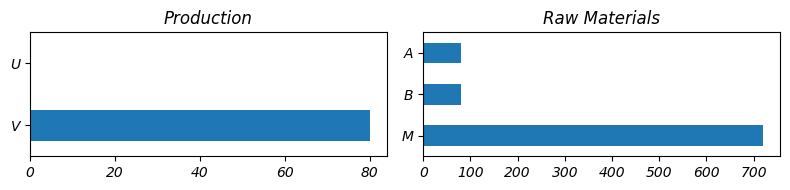

In [32]:
# Step 7B: Visualize Solution with Matplotlib
# --------------------------------------------
# We now generate a simple bar chart to illustrate production and resource usage.

import matplotlib.pyplot as plt

# Create a 1-row, 2-column subplot layout
fig, ax = plt.subplots(1, 2, figsize=(8, 2))

# Plot production as a horizontal bar chart
production.plot(
    ax=ax[0],
    kind="barh",
    title="Production"
)

# Plot raw materials/labor usage as a horizontal bar chart
raw_materials.plot(
    ax=ax[1],
    kind="barh",
    title="Raw Materials"
)

# Invert y-axis so that items are ordered top-to-bottom
ax[0].invert_yaxis()
ax[1].invert_yaxis()

# Improve layout spacing
plt.tight_layout()
plt.show()


In [33]:
%%writefile production_planning_basic.mod

# Decision variables
var x_M >= 0;
var x_A >= 0, <= 80;
var x_B >= 0, <= 100;
var y_U >= 0, <= 40;
var y_V >= 0;

# Auxiliary variables
var revenue = 270 * y_U + 210 * y_V;
var cost    = 10 * x_M + 50 * x_A + 40 * x_B;

# Objective function
maximize profit: revenue - cost;

# Constraints
s.t. raw_materials: 10 * y_U + 9 * y_V <= x_M;
s.t. labor_A:      2 * y_U + 1 * y_V <= x_A;
s.t. labor_B:      1 * y_U + 1 * y_V <= x_B;


Writing production_planning_basic.mod


In [34]:
from amplpy import AMPL

# Create AMPL instance
ampl = AMPL()

# Load model from file
ampl.read("production_planning_basic.mod")

# Solve using 'highs' or 'cbc'
ampl.set_option('solver', 'highs')
ampl.solve()

# Optional: confirm success
assert ampl.solve_result == "solved", ampl.solve_result


HiGHS 1.10.0HiGHS 1.10.0: optimal solution; objective 2400
2 simplex iterations
0 barrier iterations
